In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

from typing import Any, Callable, Sequence, Optional

import pathlib
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [2]:
current_dir = pathlib.Path().resolve()
PLANE_data_path = current_dir / 'Data'
assert PLANE_data_path.exists()

def load(name):
    return np.load(PLANE_data_path / name)

test_data_200 = load('test_data2000-200.npy')
test_data_200 = np.array(test_data_200)

test_data_1k = load('test_data1000-1000.npy')
test_data_1k = np.array(test_data_1k)

test_data_new_1k = load('test_data500-1000.npy')
test_data_new_1k = np.array(test_data_new_1k)

test_data_2k = load('test_data50-2000.npy')
test_data_2k = np.array(test_data_2k)

test_data_3k = load('test_data30-3000.npy')
test_data_3k = np.array(test_data_3k)

large_test_data_3k = load('test_data100-3000.npy')
large_test_data_3k = np.array(large_test_data_3k)

test_data_6k = load('test_data70-6000.npy')
test_data_6k = np.array(test_data_6k)

In [3]:
# Define model
class DnCNN(nn.Module):
    def __init__(self, num_layers=17, num_features=64):
        super(DnCNN, self).__init__()
        layers=[nn.Sequential(nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(inplace=True))]
        for i in range(num_layers - 2):
            layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(num_features),
                                       nn.ReLU(inplace=True)))
        layers.append(nn.Conv2d(num_features, 1, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)
        
        self._initialize_weights()
        
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

        
    def forward(self, inputs):
        y = inputs
        residual = self.layers(y)
        #return residual
        return y - residual
    
    
    
# Define model
class DnCNN_B(nn.Module):
    def __init__(self, num_layers=20, num_features=64):
        super(DnCNN_B, self).__init__()
        layers=[nn.Sequential(nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(inplace=True))]
        for i in range(num_layers - 2):
            layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(num_features),
                                       nn.ReLU(inplace=True)))
        layers.append(nn.Conv2d(num_features, 1, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)
        
        self._initialize_weights()
        
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

        
    def forward(self, inputs):
        y = inputs
        residual = self.layers(y)
        #return residual
        return y - residual

This version of the function puts the cut on the images before the `for loop` for the plotting. Want to see if there will be a noticeable difference if the cut on the image pixels is done before or after the `for loop`. I doubt there will be, but just want to make sure.

In [4]:
def show_model_flow_comp_grid(model, param_name, dataset, start_idx, num_samps, size):    
    """
    Function to display a comparison of the input, residual, and truth image for 
    multiple samples from the trained DnCNN-B model
    
    Parameters:
    -----------
    model: torch.nn.module
           The DnCNN-B architecture as described in Zheng et al.
    model_pth: .pth file 
           A file that contains the weights of a trained DnCNN model.
    dataset: np.ndarray
           Numpy array of pairs of noisy/clean images
    num_samps: int
           Number of samples to be plotted
    start_idx: int
           Index of the sample you want to start plotting from
    size: int
           How large you want the cut out of the image to be 
           
           For example:
           If you have a 1000x10000 image you want to train & test, but 
           to be able to compare between other models trained on say
           200x200 you want to cut your trained 1000x1000 image model
           down to 200x200 for an easy head-to-head comparison
    """
    # Loading model & model weights 
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / param_name
    
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval();
    # telling pytorch this is for inference and not learning, so keeps the weights unchanged
    with torch.no_grad():
        #print(torch.cuda.memory_summary(device=device, abbreviated=False))

        # Load noisy images to GPU
        test_noise = torch.Tensor(dataset[0][start_idx:start_idx+num_samps])
        test_noise = test_noise.to(device)
        
        # Load clean images 
        test_clean = dataset[1][start_idx:start_idx+num_samps]

        # Obtain output of DnCNN model & convert from GPU tensor to np.array
        torch.cuda.empty_cache()
        output = model(test_noise)
        resid_img = output.cpu().detach().numpy()
        
        # Convert input of DnCNN model & convert from GPU tensor to np.array
        test_noise = test_noise.cpu().detach().numpy()

        # Create a tuple of the 3 different types of data,
        # Indexing them from the starting index of the first sample to be plotted
        # to the num of samples to be plotted
        # In a tuple so the for loop can plot them all together as one func
        
        data_tuple = (test_noise,
                      resid_img,
                      test_clean)
        
        cols = ['{}'.format(col) for col in ['Input', 'Output', 'Truth']]
        
        fig, axes = plt.subplots(num_samps, 3, figsize=(26, 22))
        # Sets the column labels
        for ax, col in zip(axes[0], cols):
            ax.set_title(col, fontsize=30)
        
        for i in range(num_samps):
            # Convert data from GPU tensor to np.array & obtain scaling for plots
            # Getting vmin/vmax for each sample from its noisy_img sample
            vmin, vmax = np.percentile(data_tuple[0][i], (1,99))
            for j in range(3):
                axes[i, j].imshow(data_tuple[j][i][0][:size,:size], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
                axes[i, j].axis('off')
                plt.tight_layout()

Trained 200x200 model w/ inference on 200x200 test data w 50 epochs

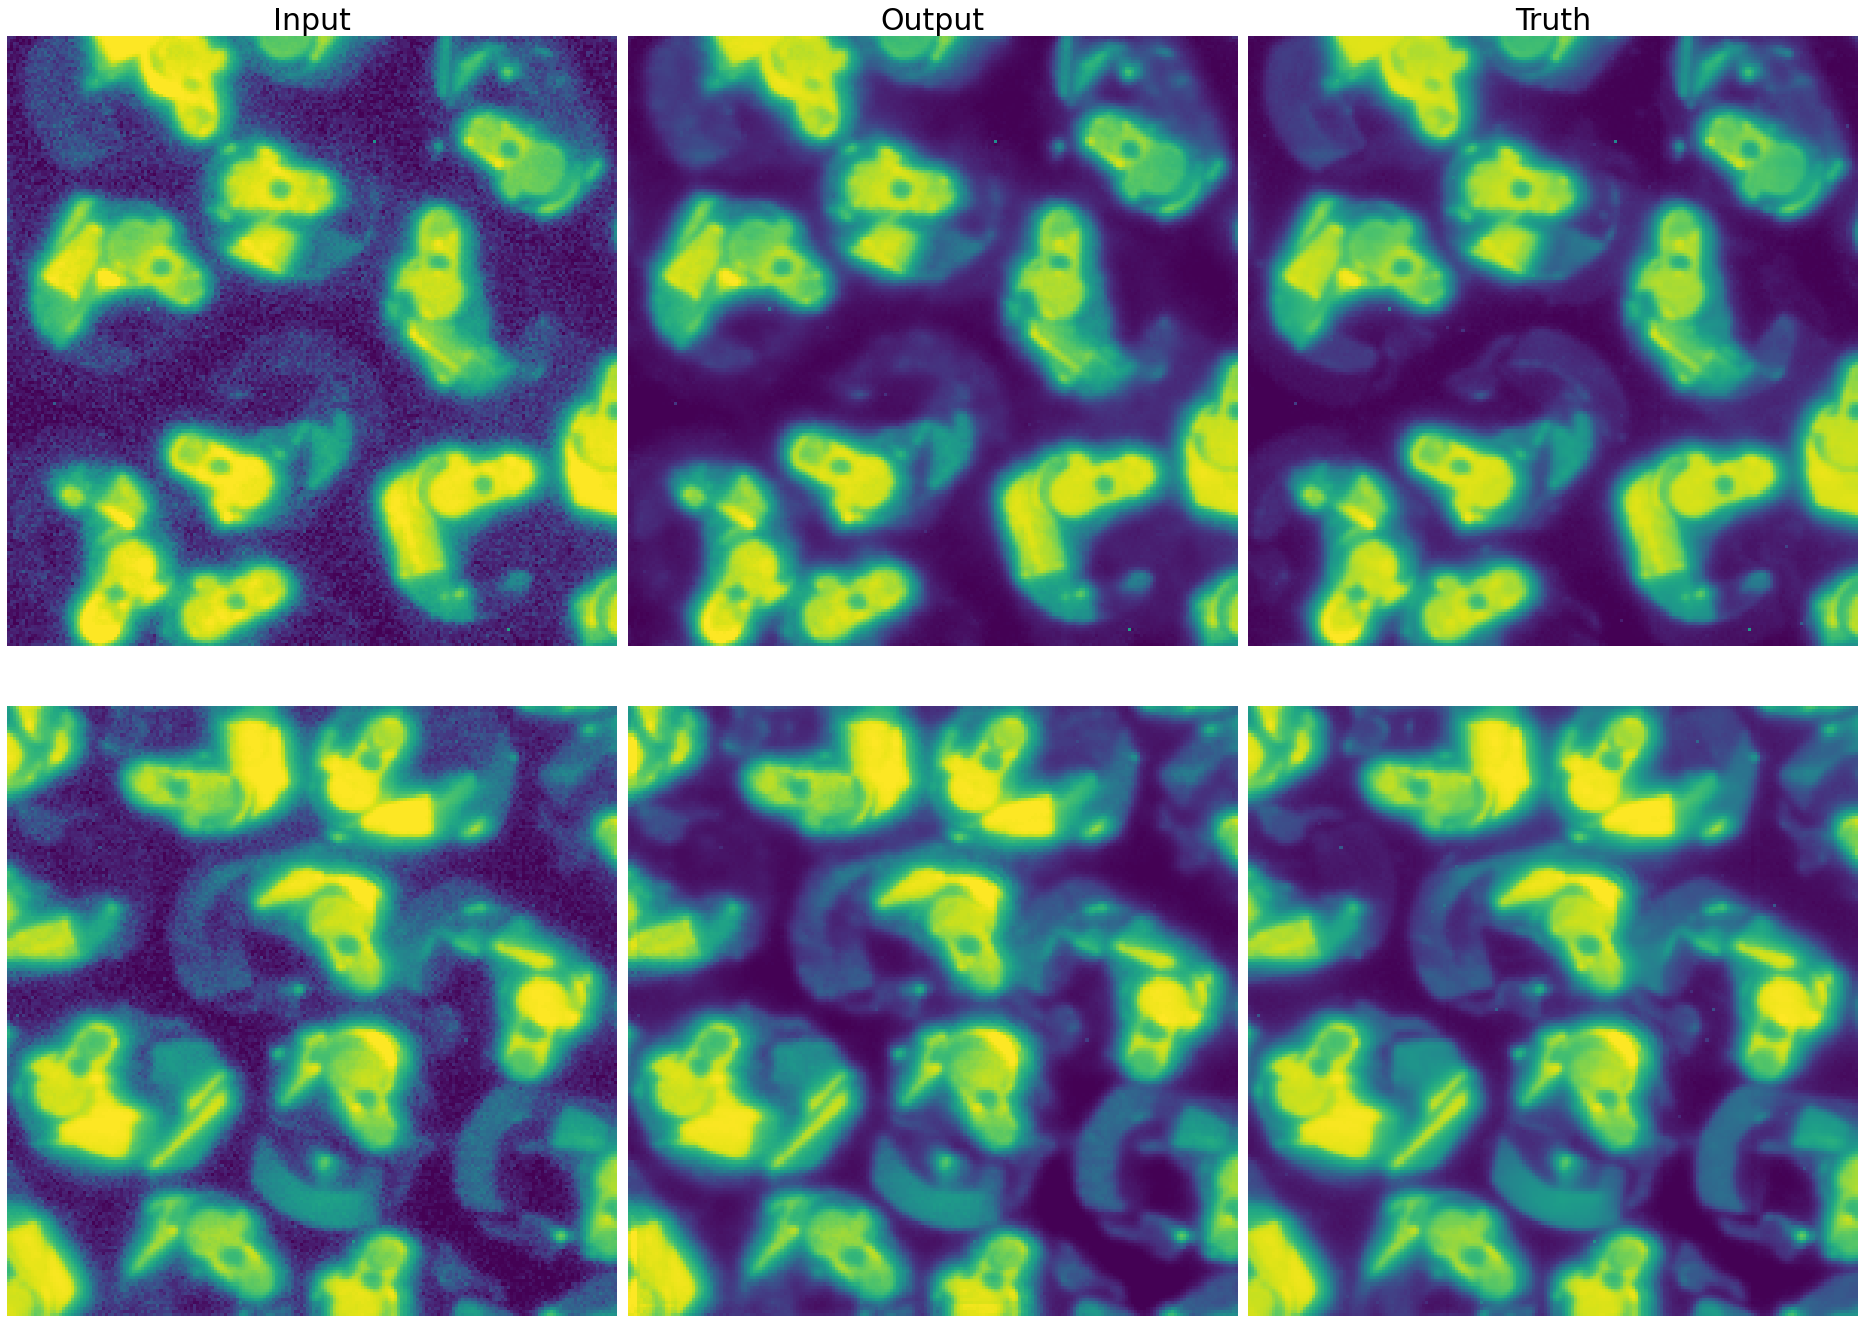

In [5]:
show_model_flow_comp_grid(model=DnCNN,
                          param_name="model_bs64_e50.pth",
                          dataset=test_data_200,
                          start_idx=2,
                          num_samps=2,
                          size=200)

Trained 1000x1000 model w/ inference on 1000x1000 test data w 50 epochs

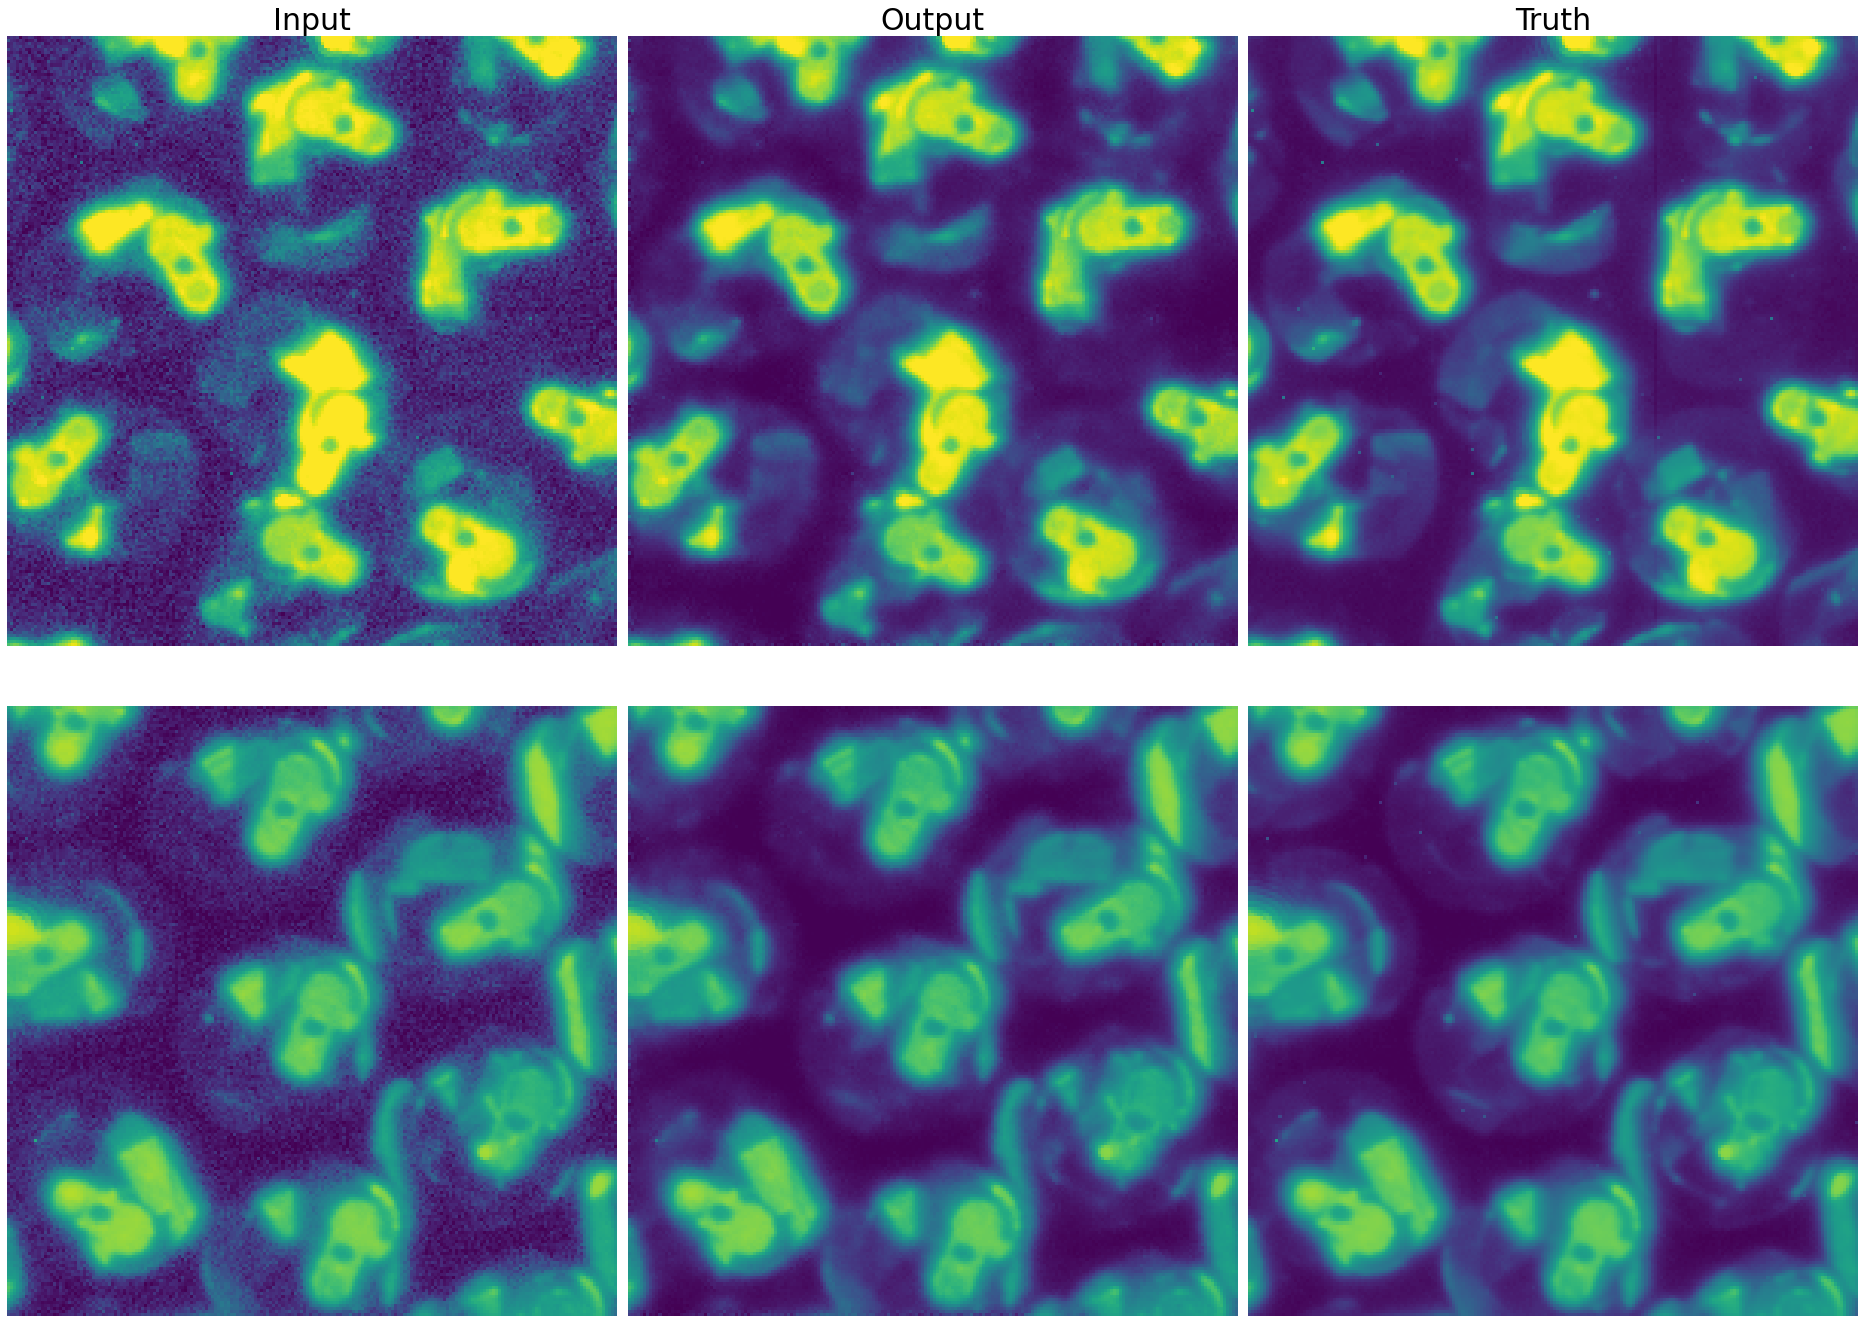

In [6]:
show_model_flow_comp_grid(model=DnCNN,
                          param_name="1k_model_bs64_e50.pth",
                          dataset=test_data_1k,
                          start_idx=0,
                          num_samps=2,
                          size=200)

Trained 1000x1000 model w/ inference on 1000x1000 test data w 75 epochs & new test data

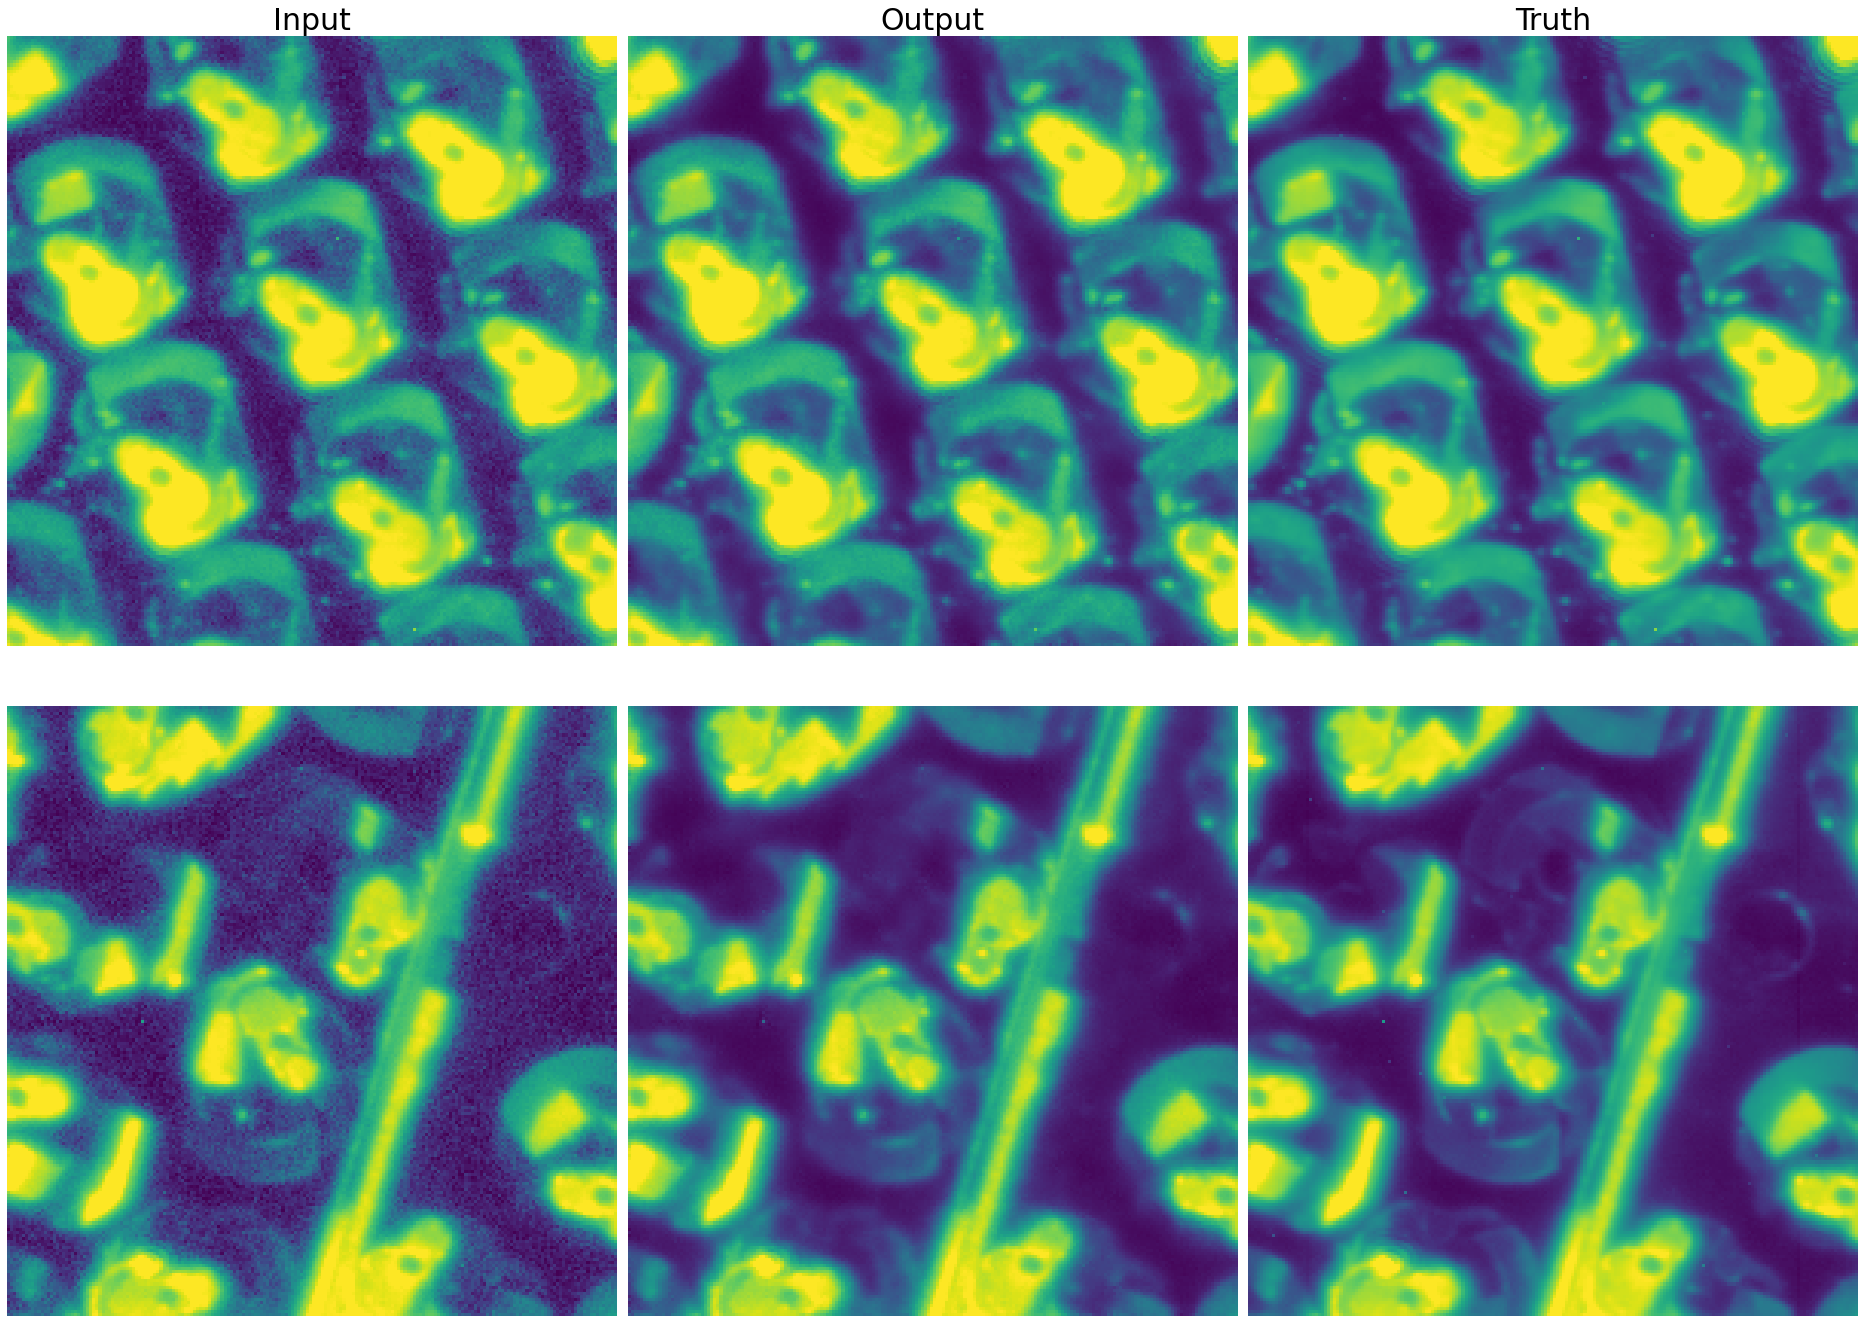

In [7]:
show_model_flow_comp_grid(model=DnCNN,
                          param_name="1k_model_bs64_e75.pth",
                          dataset=test_data_new_1k,
                          start_idx=1,
                          num_samps=2,
                          size=200)

Trained 2000x2000 model w/ inference on 2000x2000 test data

In [8]:
# show_model_flow_comp_grid(model=DnCNN,
#                           param_name="2k_model_bs32_e200.pth",
#                           dataset=test_data_2k,
#                           start_idx=2,
#                           num_samps=2,
#                           size=200)

Trained 1000x1000 model w/ inference on 1000x1000 sub_image of 6000x6000 test data

In [9]:
test_data_6k.shape

(2, 70, 1, 6000, 6000)

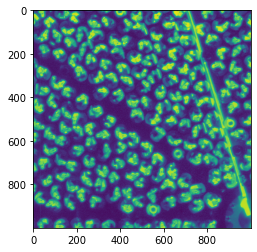

In [10]:
plt.imshow(test_data_6k[0][0][0][2000:3000,2000:3000])

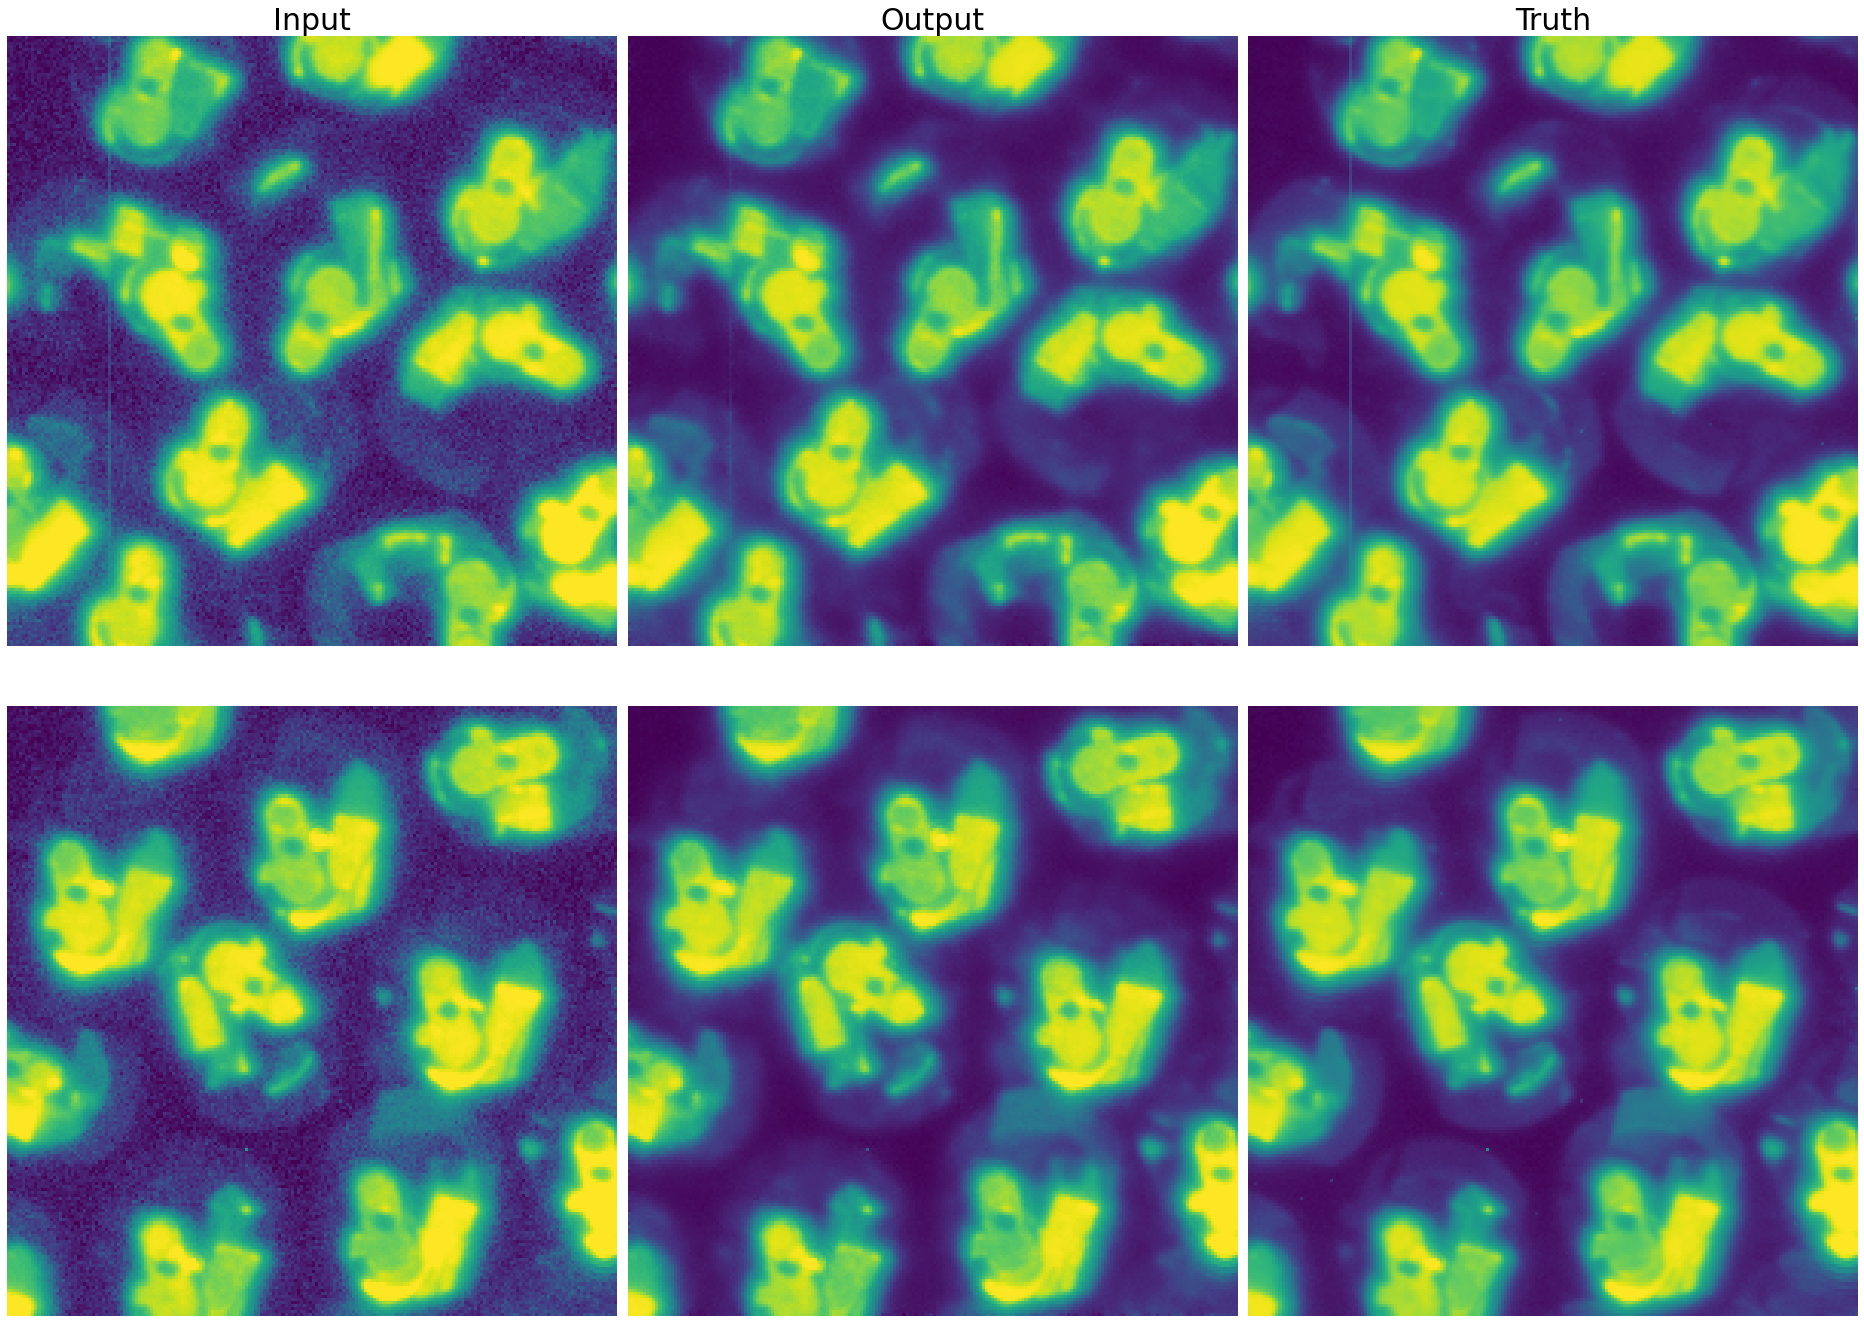

In [11]:
show_model_flow_comp_grid(model=DnCNN,
                          param_name="1k_model_bs64_e75.pth",
                          dataset=test_data_6k[:,:,:,2000:3000,2000:3000],
                          start_idx=6,
                          num_samps=2,
                          size=200)

Trained 1000x1000 model w/ inference on 1000x1000 test data

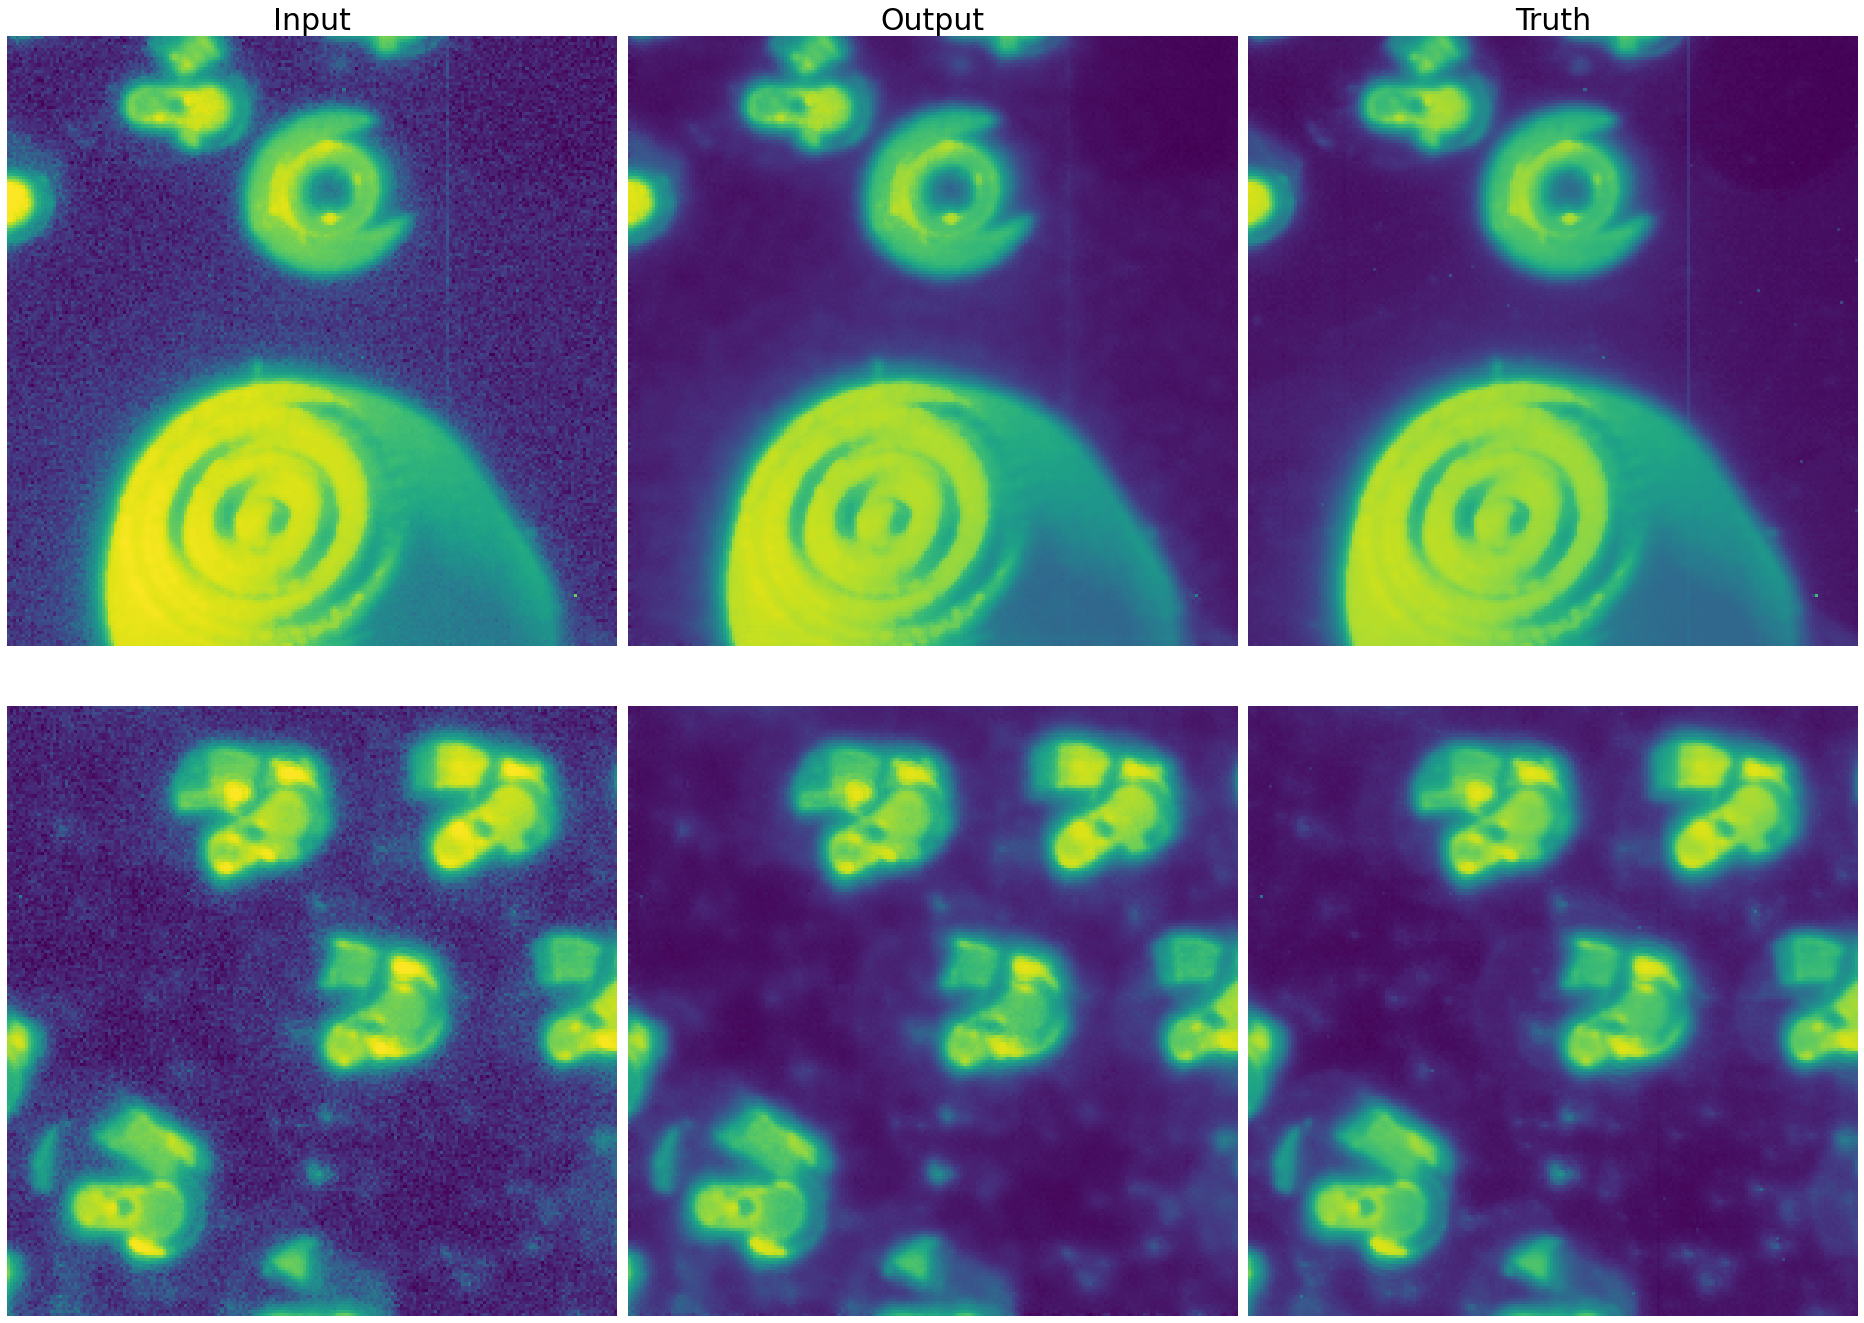

In [12]:
show_model_flow_comp_grid(model=DnCNN,
                          param_name="1k_model_bs64_e75.pth",
                          dataset=test_data_new_1k,
                          start_idx=10,
                          num_samps=2,
                          size=200)

Trained 1000x1000 model w/ inference on old 1000x1000 test data.

**NOTE:** We can se ehere there is the weird edge effects on the left hand-side of the model output. I guess maybe the data was corrupted? But that doesn't make sense because we are plotting a subimage of the data, so those pixels being corrupted for every sub-image sample doesn't make sense. And the plotting function is fine because the images above for the new model & new data works fine.

In [13]:
# show_model_flow_comp_grid(model=DnCNN,
#                           param_name="1k_model_bs64_e75.pth",
#                           dataset=test_data_1k,
#                           start_idx=0,
#                           num_samps=2,
#                           size=200)

Older trained 1000x1000 model w/ inference on 1000x1000 test data. 

**NOTE:** It has some where left-hand side edge effects. Don't know why that is happening. Wasn't happening last week. Newly trained 1000x1000 model works fine. Curious/should follow up on that next week.

In [14]:
# show_model_flow_comp_grid(model=DnCNN,
#                           param_name="1k_model_bs64_e50.pth",
#                           dataset=test_data_1k,
#                           start_idx=0,
#                           num_samps=2,
#                           size=200)

Trained 2000x2000 model w/ inference on 2000x2000 test data w 200 epochs

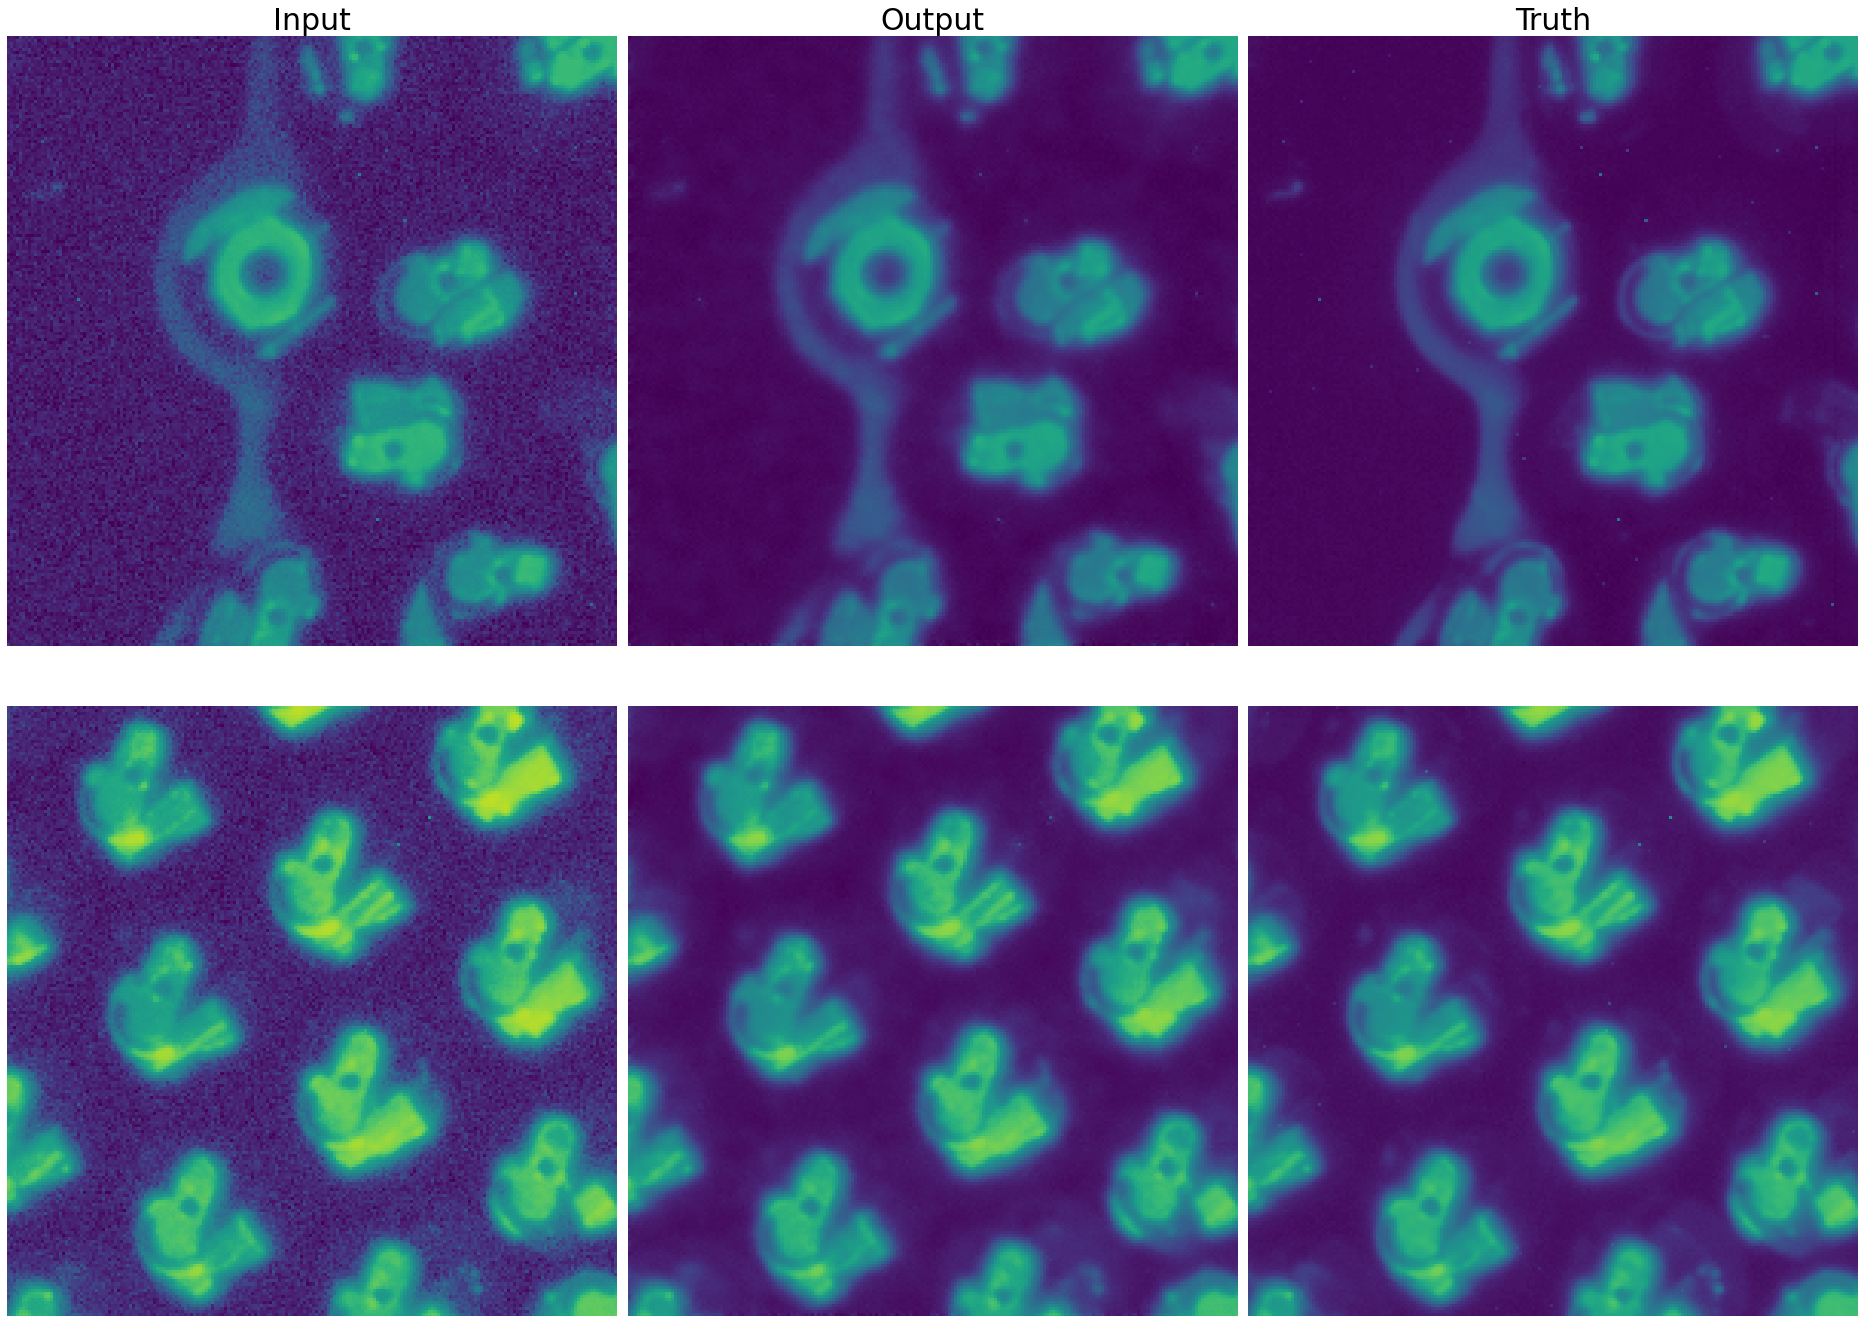

In [15]:
show_model_flow_comp_grid(model=DnCNN,
                          param_name="2k_model_bs64_e200.pth",
                          dataset=test_data_2k,
                          start_idx=19,
                          num_samps=2,
                          size=200)

Trained 3000x3000 model w/ inference on 3000x3000 test data w 200 epochs

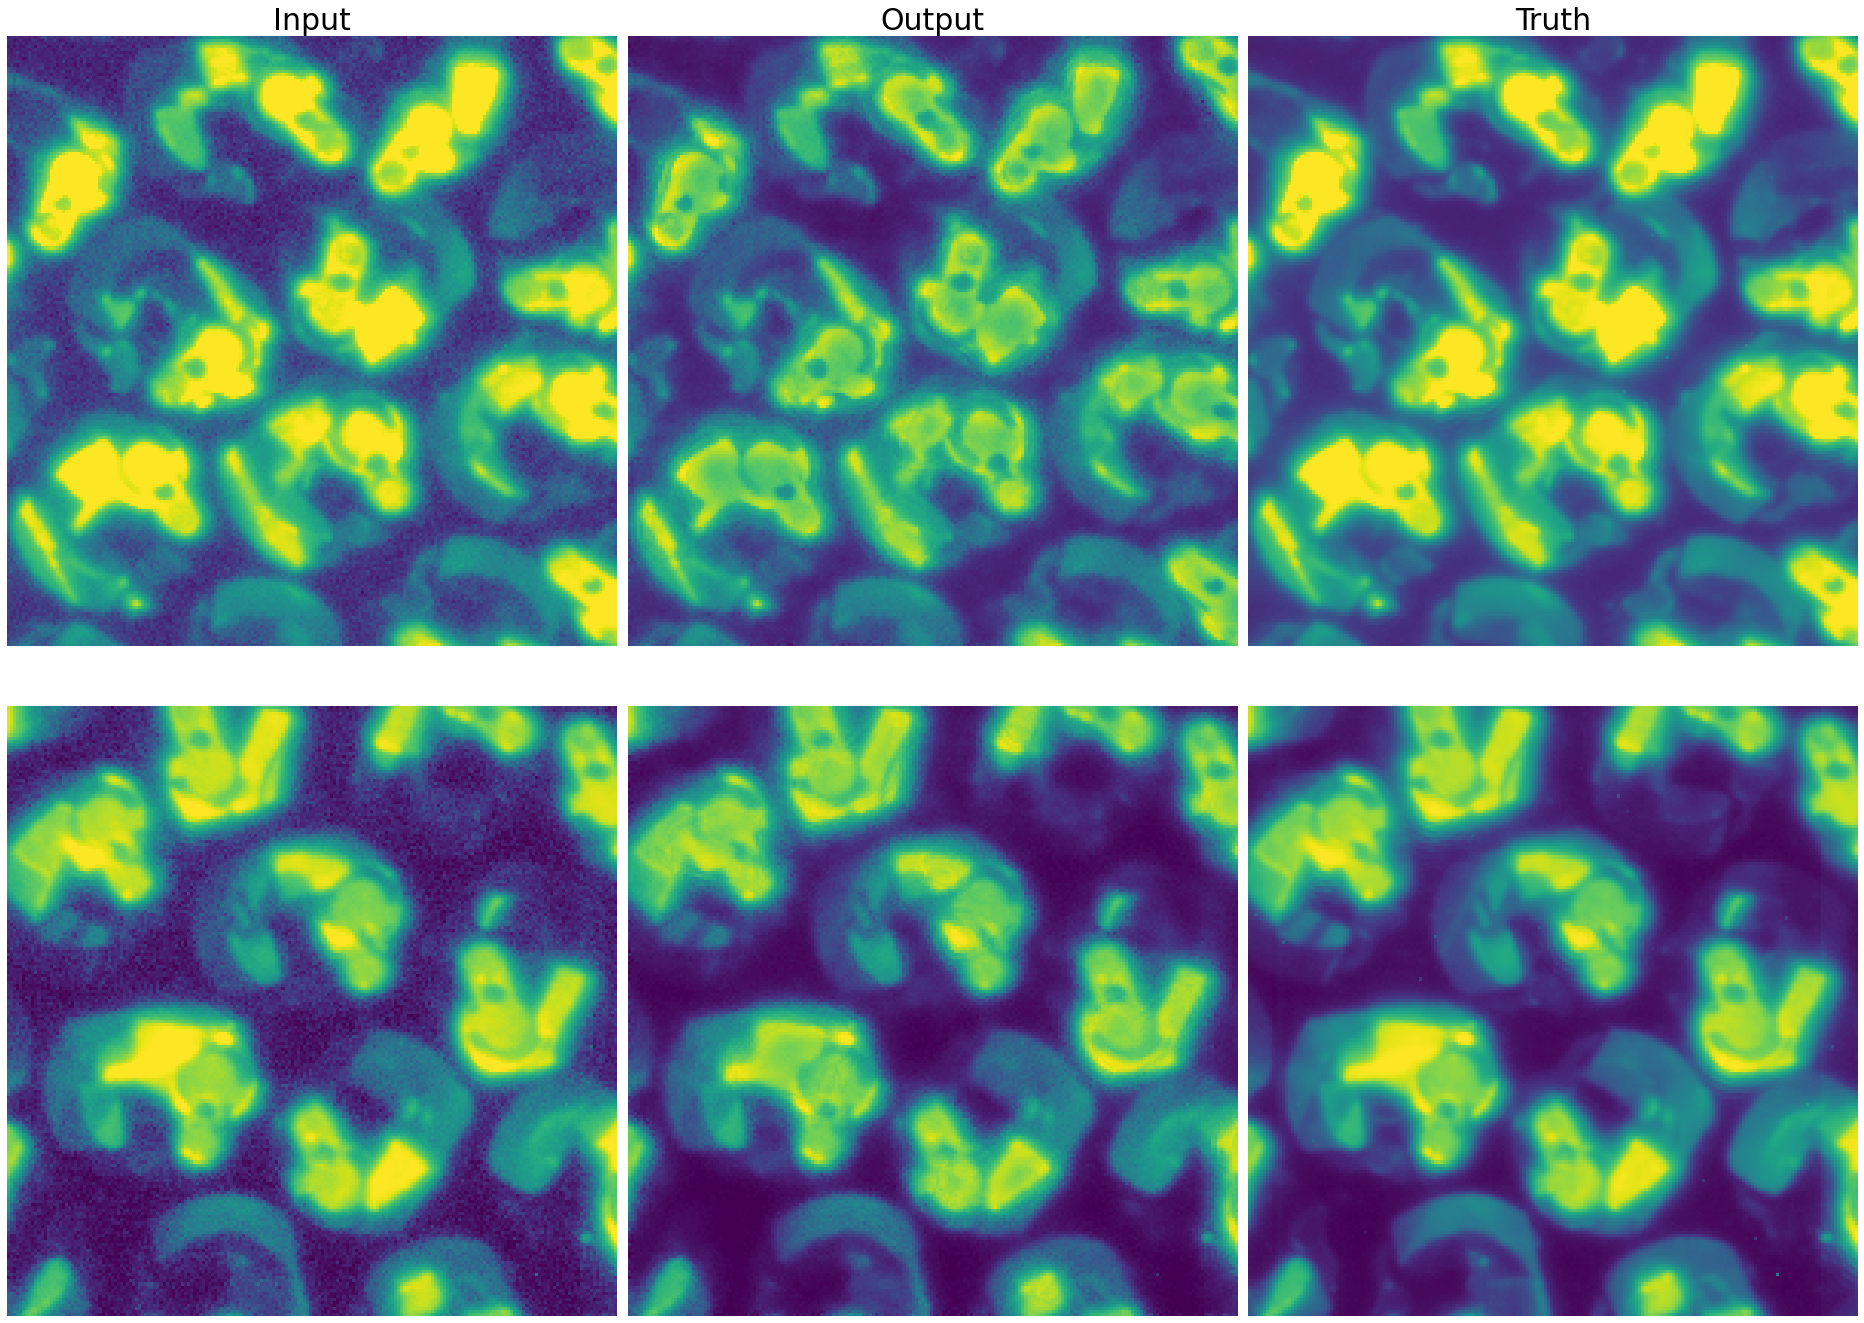

In [23]:
show_model_flow_comp_grid(model=DnCNN_B,
                          param_name="3k_model_bs64_e200.pth",
                          dataset=test_data_3k,
                          start_idx=4,
                          num_samps=2,
                          size=200)

Trained 3000x3000 model on 1400 samples w/ inference on 3000x3000 test data w/ 75

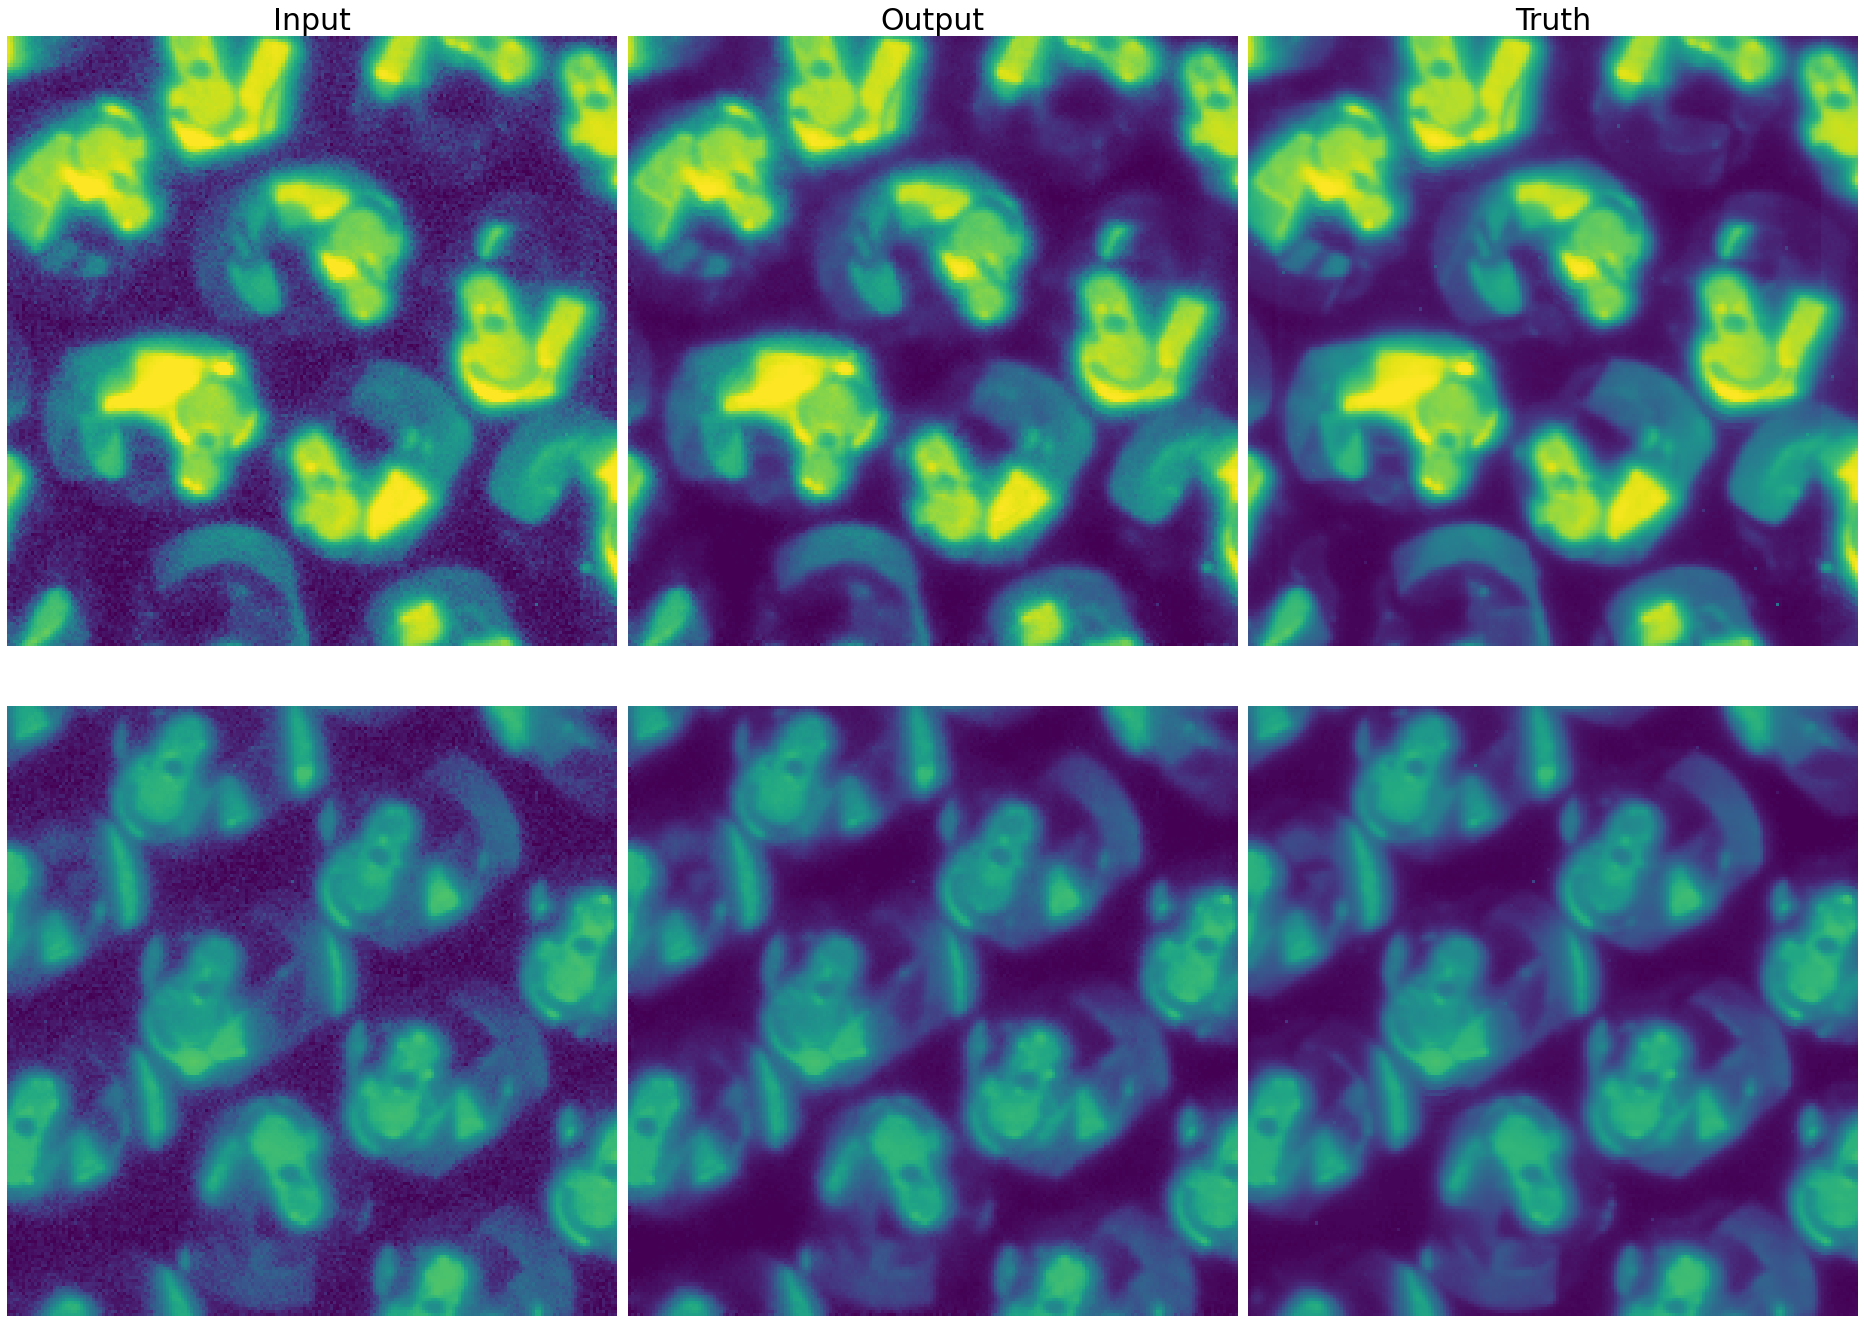

In [24]:
show_model_flow_comp_grid(model=DnCNN_B,
                          param_name="large_3k_model_bs64_e75.pth",
                          dataset=test_data_3k,
                          # dataset=large_test_data_3k,
                          start_idx=5,
                          num_samps=2,
                          size=200)

Trained 6000x6000 model w/ inference on 6000x6000 test data w 75 epochs

In [5]:
device = "cpu"
print(f"Using {device} device")

Using cpu device


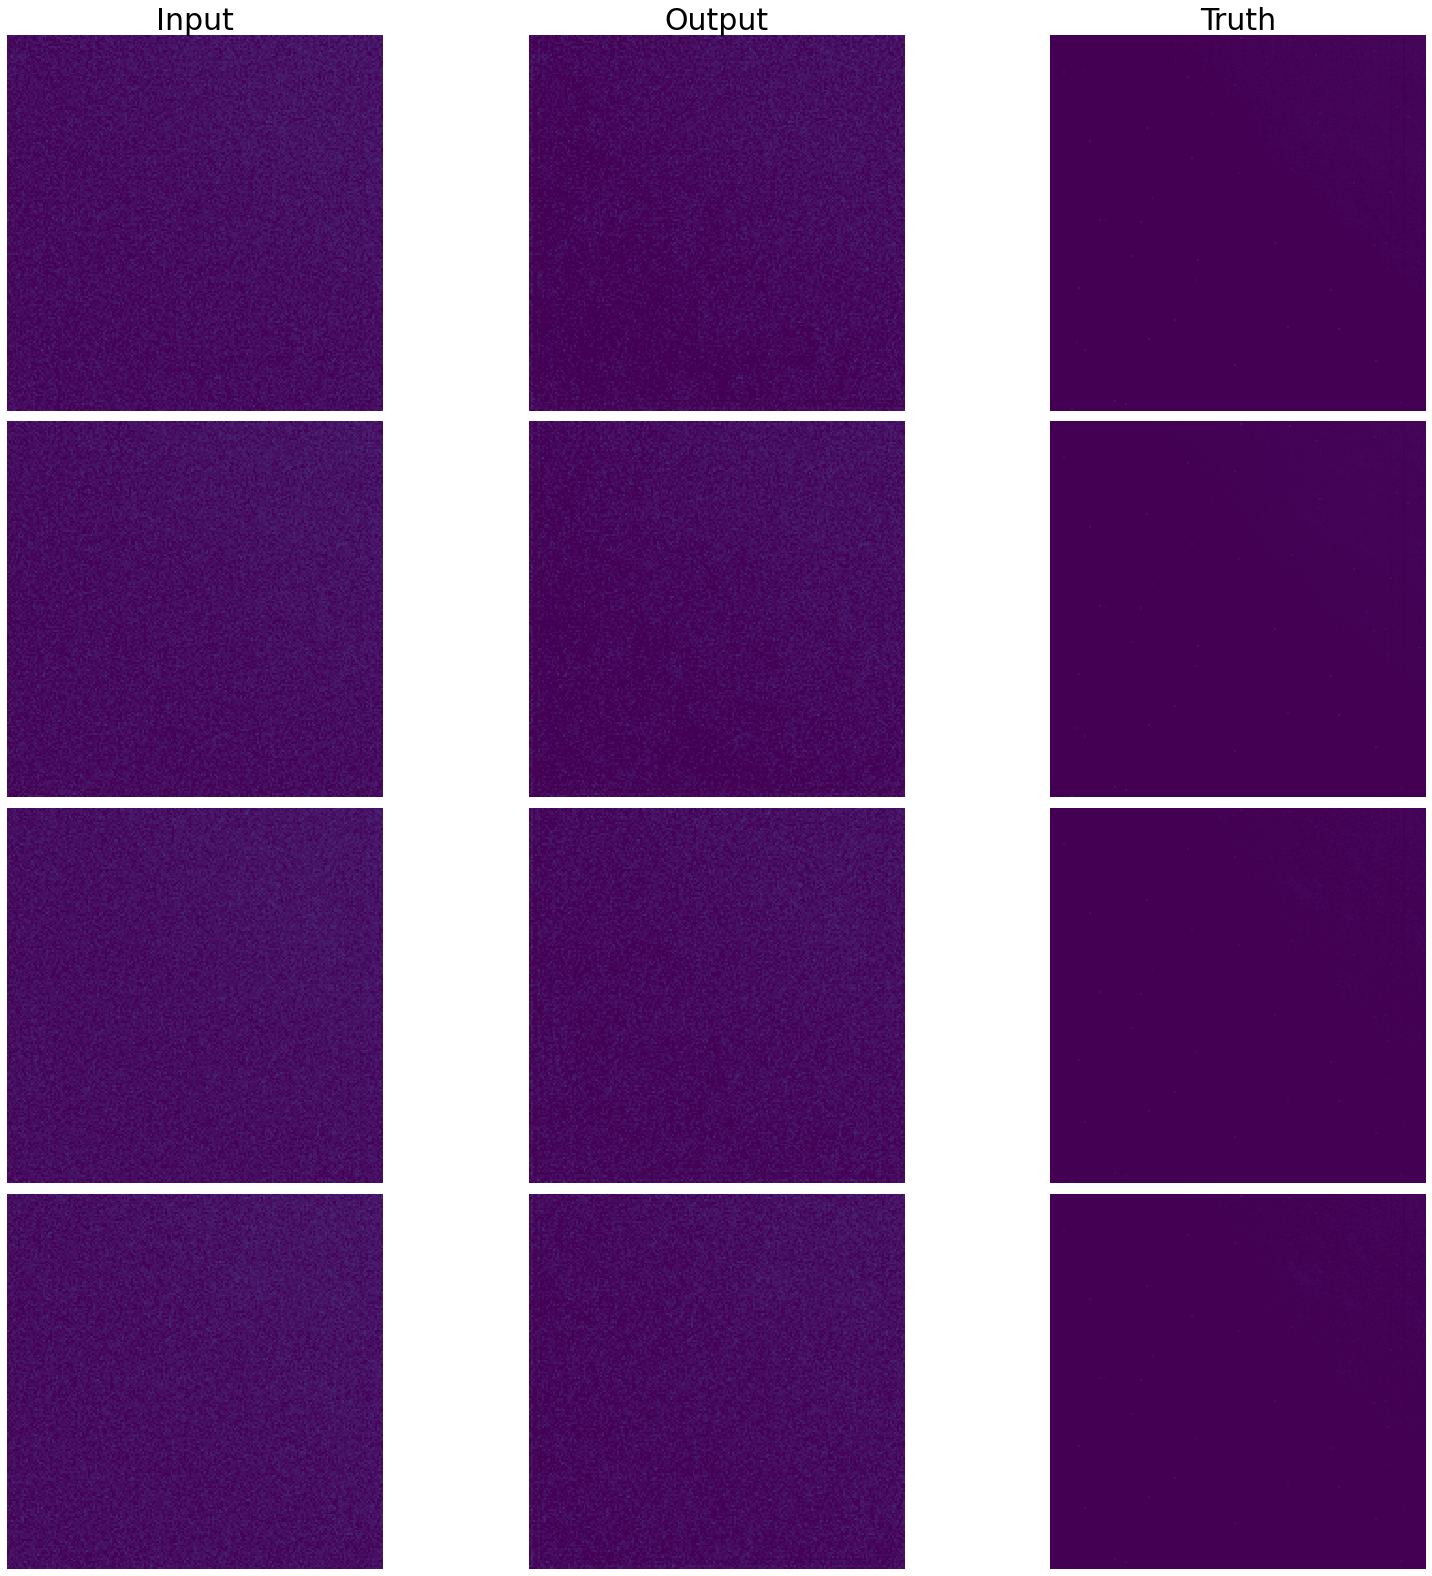

In [8]:
show_model_flow_comp_grid(model=DnCNN_B,
                          param_name="6k_model_bs64_e75.pth",
                          dataset=test_data_6k,
                          start_idx=50,
                          num_samps=4,
                          size=200)

In [ ]:
show_model_flow_comp_grid(model=DnCNN,
                          param_name="model_bs64_e50.pth",
                          dataset=test_data_200,
                          start_idx=2,
                          num_samps=2,
                          size=200)

In [ ]:
# Define model
class DnCNN_B(nn.Module):
    def __init__(self, num_layers=20, num_features=64):
        super(DnCNN_B, self).__init__()
        layers=[nn.Sequential(nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(inplace=True))]
        for i in range(num_layers - 2):
            layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(num_features),
                                       nn.ReLU(inplace=True)))
        layers.append(nn.Conv2d(num_features, 1, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)
        
        self._initialize_weights()
        
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

        
    def forward(self, inputs):
        y = inputs
        residual = self.layers(y)
        #return residual
        return y - residual

In [ ]:
show_model_flow_comp_grid(model=DnCNN_B,
                          param_name="6k_model_bs64_e75.pth",
                          dataset=test_data_6k,
                          start_idx=2,
                          num_samps=2,
                          size=200)

In [ ]:
noisy_test_1k = test_data_1k[0]
clean_test_1k = test_data_1k[1]

data_tuple = (noisy_test_1k, clean_test_1k)

# see if it'll cut it too 200x200 pic
start_idx = 0
num_samps = 2
size = 200

# test_noise_2_200 = data_tuple
# print(len(data_tuple))
# print(data_tuple[0].shape)

# data_tuple = [clean/resid/noise sample] [# of samples] [channel index] [height of img, width of img]
test_noise_2_200 = data_tuple[0][0][0][:200, :200]
# print(test_noise_2_200.shape)

test_noise_2_200 = data_tuple[0][:20][0][:200][:200]
# print(test_noise_2_200.shape)



# print(type(data_tuple)) # Tuple of noise/resid/clean image sets
# print(len(data_tuple)) 
# print()
# print(type(data_tuple[0])) # Noise image array
# print(data_tuple[0].shape) 
# print()
# print(type(data_tuple[0][0])) # Noise image array's first sample
# print(data_tuple[0][0].shape)
# print(type(data_tuple[0][0][0])) # Noise image array's first sample + channel number
# print(data_tuple[0][5][0].shape)
# print()

# single_sample_1k_1k = data_tuple[0][0][0]
# print(single_sample_1k_1k.shape)
# print(single_sample_1k_1k[:200,:200].shape)

# ten_1k_1k_samps = data_tuple[0][:10][0]
# print(ten_1k_1k_samps.shape)
# print(ten_1k_1k_samps[:200,:200].shape)

# ten_1k_1k_samps = data_tuple[0][0][:200,:200]
# print(ten_1k_1k_samps.shape)
# print(ten_1k_1k_samps[:200,:200].shape)

single_sample_1k_1k = data_tuple[0][0][0][:200,:200]
print(single_sample_1k_1k.shape)
# print(single_sample_1k_1k[:200,:200].shape)

In [ ]:
test_data_6k = load('test_data70-6000.npy')
test_data_6k = np.array(test_data_6k)
test_noise_6k = test_data_6k[0]

In [ ]:
current_dir = pathlib.Path().resolve()
model_params_path = current_dir / 'Model_params'
assert model_params_path.exists()
model_path = model_params_path / "6k_model_bs64_e50.pth"

dataset = test_data_6k

model = DnCNN()
model.to(device)
model.load_state_dict(torch.load(str(model_path)))
model.eval();
# telling pytorch this is for inference and not learning, so keeps the weights unchanged
with torch.no_grad():

    # Load noisy images to GPU
    test_noise = torch.Tensor(test_noise_6k[0][0])
    test_noise = test_noise.to(device)

    # Load clean images 
    test_clean = dataset[1][start_idx:start_idx+num_samps]

    # Obtain output of DnCNN model & convert from GPU tensor to np.array
    torch.cuda.empty_cache()
    output = model(test_noise)
    resid_img = output.cpu().detach().numpy()

In [ ]:
current_dir = pathlib.Path().resolve()
model_params_path = current_dir / 'Model_params'
assert model_params_path.exists()
model_path = model_params_path / "1k_model_bs64_e50.pth"

test_noise_1k = test_data_1k[0]
test_noise_1k = test_noise_1k[:2]

model = DnCNN()
model.to(device)
model.load_state_dict(torch.load(str(model_path)))
model.eval();
# telling pytorch this is for inference and not learning, so keeps the weights unchanged
with torch.no_grad():

    # Load noisy images to GPU
    test_noise = torch.Tensor(test_noise_1k)
    test_noise = test_noise.to(device)

    # Load clean images 
    test_clean = dataset[1][start_idx:start_idx+num_samps]

    # Obtain output of DnCNN model & convert from GPU tensor to np.array
    torch.cuda.empty_cache()
    output = model(test_noise)
    resid_img = output.cpu().detach().numpy()

In [ ]:
current_dir = pathlib.Path().resolve()
model_params_path = current_dir / 'Model_params'
assert model_params_path.exists()
model_path = model_params_path / "6k_model_bs64_e50.pth"

test_noise_6k = test_data_6k[0]
test_noise_6k = test_noise_6k[:2]

import gc
del variables
gc.collect()

print(test_noise_6k.shape)
model = DnCNN()
model.to(device)
model.load_state_dict(torch.load(str(model_path)))
model.eval();
# telling pytorch this is for inference and not learning, so keeps the weights unchanged
with torch.no_grad():

    # Load noisy images to GPU
    test_noise = torch.Tensor(test_noise_6k)
    test_noise = test_noise.to(device)
    
    
    # Obtain output of DnCNN model & convert from GPU tensor to np.array
    torch.cuda.empty_cache()
    output = model(test_noise)
    resid_img = output.cpu().detach().numpy()
    


In [ ]:
plt.imshow(test_data_6k[0][0][0])